In [1]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    EBLAbsorptionNormSpectralModel,
    TemplateSpectralModel
)
from gammapy.catalog import CATALOG_REGISTRY
from astropy.io import ascii

import warnings
from gammapy.utils.deprecation import GammapyDeprecationWarning
from astropy.utils.exceptions import AstropyWarning

import glob, os, itertools

In [2]:
# 1. Hide the Gammapy “FixedPointingInfo will be required” notice
warnings.filterwarnings("ignore", category=GammapyDeprecationWarning)

# 2. Hide the Astropy polar-motion / IERS table notice
warnings.filterwarnings("ignore", category=AstropyWarning)

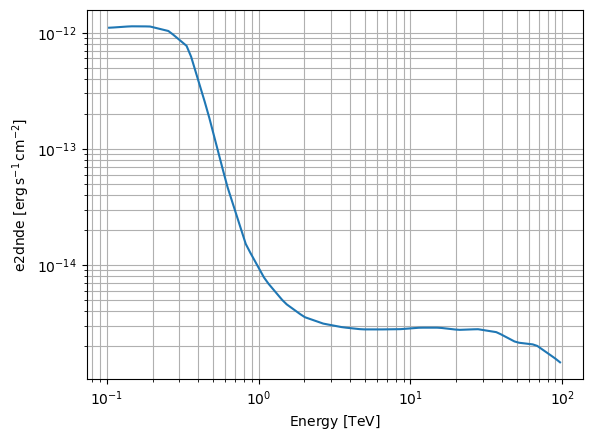

In [3]:
# Source
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# Template spectral model. Defined by custom tabular values from Inoue+ 2022
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Inoue_2022_wind.dat")

data['Frequency[Hz]'] = 10**data['logFrequency[Hz]'] 
data['flux[ergcm^-2s^-1]'] = 10**data['logflux[ergcm^-2s^-1]']

energy = data['Frequency[Hz]'] * u.Hz
values = data['flux[ergcm^-2s^-1]'] *u.erg / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV, equivalencies=u.spectral())

values = values.to(u.MeV / (u.cm ** 2.0 * u.s))
values_MeV = values / energy_MeV**2  # divide by energy to get dN/dE

spectral_model = TemplateSpectralModel(energy=energy_MeV, values=values_MeV)

spatial_model = PointSpatialModel.from_position(target_position)

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=spatial_model,
                    name="NGC_1068",
                    )

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

# Plotting the model
energy_bounds = [0.1, 100] * u.TeV
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts)
plt.grid(which="both")

In [4]:
# Define the full model
models = Models([sky_model, bkg_model])
print(models)

# save it to disk
file_model = "./Wind_NGC_1068.yaml"
models.write(file_model, write_covariance=False, overwrite=True)

irf_filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
IRF = load_irf_dict_from_file(irf_filename)

Models

Component 0: SkyModel

  Name                      : NGC_1068
  Datasets names            : None
  Spectral model type       : TemplateSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    lon_0                         :     40.669   +/-    0.00 deg         
    lat_0                         :     -0.013   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [5]:
#Ereco ed Etrue must to be different: Etrue must have a larger range in order to reconstruct in the correct way (knowledge of
#the whole photon energy extension)

energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
    )

# for the Edisp
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "200 TeV", nbin=20, per_decade=True, name="energy_true"
    )

migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra" #If node_type = ‘edge’ then bounds correspond to the lower
                                                      #  and upper bound of the first and last bin.
    ) 

pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(40.169 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg"),
)      

# let's define the geometry of the simulation:
geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,           
    width=(4, 4),         # gammapy uses a square not a circle 
    binsz=0.02,           # pixel size
    frame="icrs",
    axes=[energy_axis],    #in reco energy
)
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(200), np.int64(200), 30)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 40.2 deg, -0.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 40.2 deg, -0.0 deg



In [6]:
# Get all files in the ./sims directory
files = glob.glob('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/*.fits')

# Loop and delete each file
for f in files:
    if os.path.isfile(f):
        os.remove(f)
        print(f"Deleted file: {f}")

Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs14.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs0.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs18.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs19.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs1.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs15.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs12.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs6.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/events_obs7.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/

In [7]:
# tstart_obs = [0.083, 3, 10, 20, 25, 40, 80, 100, 200, 250] * u.d
# livetime_obs = [8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5] * u.hr
# angle_wobble = [0, 90, 180, 270, 0, 90, 180, 270, 0, 90] * u.deg

# Parameters
total_hours = 11
obs_duration = 0.5  # 30 minutes in hours
n_obs = int(total_hours / obs_duration)

# Generate tstart_obs with increasing values (non-simultaneous), spread out in time
# We use an arbitrary starting point and step to ensure separation
tstart_obs = np.linspace(0.083, 5, n_obs) * u.d

# All observations are 30 minutes
livetime_obs = np.full(n_obs, obs_duration) * u.hr

# Generate angle_wobble cycling through [0, 90, 180, 270]
base_angles = [0, 90, 180, 270]
angle_wobble = [base_angles[i % 4] for i in range(n_obs)] * u.deg

location = observatory_locations["cta_north"]

reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc")

#### MapDataset object with zer0-filled map
empty = MapDataset.create(
        geom,                               
        energy_axis_true=energy_axis_true,       #for the IRF maps
        migra_axis=migra_axis,                   #for the Edisp map
        name="my-dataset",                       #the name that will read the FoVBKG
            )

### Make maps for a single observation
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"]) #which maps to make (by default all)


for i, (tobs, liveobs, wobobs) in enumerate(zip(tstart_obs, livetime_obs, angle_wobble)):

    print(f"Simulating observation {i}, tstart = {tobs}, livetime = {liveobs}")

    pointing_obs = target_position.directional_offset_by(wobobs, 0.5*u.deg)
    obs = Observation.create(
                            obs_id=i, 
                            pointing=pointing_obs, 
                            livetime=liveobs, 
                            irfs=IRF,
                            location=location,
                            reference_time = reference_time, 
                            tstart = tobs
                  )    

    dataset = maker.run(empty.copy(), obs) 

    bkg_model = bkg_model.copy()
    bkg_model.datasets_names = [dataset.name]   # <-- relink

    dataset.models = Models([sky_model, bkg_model])

    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, obs)

    obs.events = events
    obs.write(f"events_obs{i}.fits", include_irfs=False, overwrite=True)

Simulating observation 0, tstart = 0.083 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 1, tstart = 0.3171428571428571 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 2, tstart = 0.5512857142857143 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 3, tstart = 0.7854285714285714 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 4, tstart = 1.0195714285714286 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 5, tstart = 1.2537142857142856 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 6, tstart = 1.4878571428571428 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 7, tstart = 1.7219999999999998 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 8, tstart = 1.956142857142857 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 9, tstart = 2.1902857142857144 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 10, tstart = 2.4244285714285714 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 11, tstart = 2.6585714285714284 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 12, tstart = 2.892714285714286 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 13, tstart = 3.126857142857143 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 14, tstart = 3.3609999999999998 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 15, tstart = 3.595142857142857 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 16, tstart = 3.829285714285714 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 17, tstart = 4.063428571428571 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 18, tstart = 4.297571428571429 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 19, tstart = 4.531714285714285 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 20, tstart = 4.765857142857143 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 21, tstart = 5.0 d, livetime = 0.5 h


The meta information will be empty here.
